## Chapter 9. Dynamic macro I: Infinite horizon models (continued)
Reference: Fehr, H. and Kindermann, F. 2018. <i>Introduction to Computational Economics Using Fortran.<i/> Oxford University Press. pp. 323-405.

In [1]:
import numpy as np
from discretize_tools import rouwenhorst, grow_grid
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import root, minimize
import matplotlib.pyplot as plt
from simulate import simulate_AR
plt.rcParams["figure.figsize"] = (11, 5)
from linear import linint
import time

In [2]:
# Program 9.10 Iterative calculation of the value function

#setting parameters
γ = 1/1.5 #intertemporal elasticity of substitution
egam = 1 - 1/γ #denominator of utility function
growth = 0.0185 # population growth rate
β = 0.98 * (1 + growth)**egam #discount factor
α = 0.3 #capital share
δ = 0.075 #depreciation
ρ = 0.6 #persistence
σe = 0.09 * (1 - ρ**2) #st.d. of noise e
τw = 0.27 #income tax rate
gy = 0.217 #fraction of government expenditure

al = 0 #lower bound of a
au = 100 #upper bound of a
agrow = 0.01 #growth rate of a
tolin = 1e-7 #inside tolerance
tolout = 1e-5 #outside tolerance
itermax = 10000 #maximum iterature number

na = 1000 #number of a grids
ns = 7 #number of shock states
RHS = np.zeros((na,ns)) #initialize RHS of foc

c= np.zeros((na,ns)) #initialize consumption

In [3]:
def initialize():
    """THis property initialize the parameters and variables used in the model"""
    global η, π, weight, L, c, c_new, ϕ1, a
    # wage shocks, transition matrix, weight, aggregate labour supply, consumption, consumption in ieration, , savings
    η, π, weight = rouwenhorst(ρ,σe,ns, weight = True)
    η = np.exp(η)
    
    L = (η * weight).sum()
    
    a = grow_grid(al, au, agrow, n = na)
    
    
    for j in range(ns):
        c[:,j] = 0.04 *a + η[j]
    c_new = c.copy()
    
    ϕ1 = np.ones((na,ns))*(1/(na*ns))

In [4]:
def interpolate():
    """This function calculates the RHS of foc that needs to be interpolated"""
    global RHS
    for i in range(na):
        for j in range(ns): # equation 9.20 on p.380
            RHS[i,j] = π[j,:]@(c_new[i,:]**(-1/γ))
            RHS[i,j] = (β*(1+rn)*RHS[i,j])**(-γ)

In [5]:
def foc(x_in):
    """This function calculates the first-order conditions"""
    
    aplus = ((1+rn)*a_com + wn*η[is_com] - x_in)/(1 + growth) #law of motion for asset savings
    
    ale1, ari1, φ1 = linint(aplus, al, au, agrow, na) # determine the gridpoints in between this decision lies
    
    foc = x_in - (φ1*RHS[ale1, is_com] + (1 - φ1)*RHS[ari1, is_com]) # calculate foc
    
    return foc


In [6]:
def solve_household():
    """This function calculates the optimal consumption level"""
    global x_in, a_com, is_com, c_new, c
    for ite in range(itermax):
        
        interpolate()
        
        #iterate for 
        for i in range(na):
            for j in range(ns):
                a_com = a[i] #savings
                is_com = j   #shock state
                
                x_in = root(foc, x0 = c[i,j]).x[0] #optimal consumption level
                if x_in > ((1+rn)*a_com + wn*η[is_com]-al): #check for borrowing constraint
                    x_in = (1+rn)*a_com + wn*η[is_com]-al
                    
                c_new[i,j] = x_in #update consumption
                
        con_lev = np.amax(np.abs(c_new-c)/np.amax(np.abs(c))) #get convergence level
#         print('H: Iteration = {}, error = {:.5e}'.format(ite, con_lev))
        
        if con_lev < tolin or ite == (itermax - 1):
            break
        else:
            c = c_new.copy() #update consumption
    
    return c

In [7]:
def get_distribution():
    """This property calculates for the distribution function"""
        global φ, ϕ1, ϕ_new, ale, ari
        #initialize variables
        ale = np.zeros((na,ns)) #left point matrix
        ari = np.zeros((na,ns)) #right point matrix
        φ = np.zeros((na,ns)) #left point fraction
        for i in range(na):
            for j in range(ns):
                
                aplus = ((1+rn) *a[i] + wn*η[j] - c[i,j])/(1 + growth) #aplus equation
                aplus = min(max(aplus, al), au)
                # determine the gridpoints in between this decision lies
                ale[i,j], ari[i,j], φ[i,j] = linint(aplus, al, au, agrow, na)
        # iterate until the distribution function converges
        for ite in range(1, itermax):
            ϕ_new = np.zeros((na, ns))
            for i in range(na):
                for j in range(ns):
                        ϕ_new[int(ale[i,j]),:] += π[j,:] * (φ[i,j]*ϕ1[i,j]) #equation ϕ on p.388
                        ϕ_new[int(ari[i,j]),:] += π[j,:] * ((1-φ[i,j])*ϕ1[i,j]) #equation ϕ on p.388
                
            con_lev = np.amax(np.abs(ϕ_new-ϕ1)/np.amax(np.abs(ϕ1))) # get convergence level
#             print('D: Iteration = {}, error = {:.5e}'.format(ite, con_lev))
            
            if con_lev < tolin or ite ==( itermax - 1):
                break
            else:
                ϕ1 = ϕ_new.copy() #update distribution
                
        return ϕ1

In [1]:
def asset_market(r_input):
    """This property defines equations in the asset market"""
    global K, w, Y, G, B, A, τr, rn, wn, c, ϕ
    
    r = r_input[0] # set interest rate
    
    print('r = {}'.format(r))
    
    K = (α / (r+δ))**(1/(1-α))*L # aggregate capital
    
    w = (1-α)*(K/L)**α # wage rate
    
    Y = K**α*L**(1-α) # output
    
    G = gy*Y # government expenditure
    
    B = by*Y # public debt
    
    A = K + B # aggregate asset supply (savings)
    
    τr = (G + (r-growth)*B - τw*w*L)/(r * A) # capital tax rate that balance the budget
    
    rn = r*(1 - τr) # net price of goods
    
    wn = w*(1 - τw) # net price of labour

    c = solve_household() # optimal consumption
    
    ϕ = get_distribution() # distribution function
    
    A = np.sum(a*np.sum(ϕ, axis = 1)) # aggregate savings
    
    asset_market = (A - K - B)/A # market clearing conditions
    
    print('error = {:.5e}'.format(abs(asset_market)))
    
    return asset_market

In [9]:
def solve_model():
    """This property finds the interest rate that clears all markets"""
    global r
    r = root(asset_market, x0 = 0.042, tol = tolout).x[0]

In [10]:
def value_function():
    """This function defines the value function"""
    global V, V_new
    #initialize variables
    ale2 = np.zeros((na,ns)) #a left gridpoints
    ari2 = np.zeros((na,ns)) #a right gridpoints
    φ2   = np.zeros((na,ns)) #fraction of a left gridpoints
    
    for i in range(na):
        for j in range(ns):
            
            aplus = max(((1 + rn)*a[i] + wn*η[j] - c[i,j])/(1 + growth), al) #law of motion for a
            
            ale2[i,j], ari2[i,j], φ2[i,j] = linint(aplus, al, au, agrow, na) # determine the gridpoints in between this decision lies
    
    #initialize value function      
    V = c.copy()
    #store value function
    V_new = V.copy() 

    #iterate until the value function converges
    for ite in range(itermax):
        #calculates new value function
        for i in range(na):
            for j in range(ns):
                #interpolate over all future states
                V_new[i,j] = 0
                V_new[i,j] += π[j,:] @ ((φ2[i,j] * V[int(ale2[i,j]),:] + (1-φ2[i,j])*V[int(ari2[i,j]),:])**egam)
                V_new[i,j] = (c[i,j]**egam + β*V_new[i,j])**(1/egam)
        
        con_lev = np.amax(np.abs(V_new-V)/np.amax(np.abs(V))) # get convergence level
#         print('V: Iteration = {}, error = {:.5e}'.format(ite, con_lev))
        
        if con_lev < tolin or ite == (itermax -1):
            break
        else:
            V = V_new.copy() #update value function

    return V**egam/egam


In [11]:
#count time use
tstart = time.time() # time starts

initialize() #initialize parameters and variables
by = 0.6     #setting fraction of debt, benchmark equalibrium
solve_model() #solve initial equilibrium

tend = time.time() #time ends

time_taken = tend - tstart #time spent

print('Time used: {}h{}m{}s'.format(int(time_taken/3600),int((time_taken - int(time_taken/3600)*3600 )/60),time_taken - (int(time_taken/3600)*3600 + int((time_taken - int(time_taken/3600)*3600 )/60)*60)))


r = 0.042
error = 9.68484e+00
r = 0.042
error = 9.68484e+00
r = 0.042
error = 9.68484e+00
r = 0.04200000062584877
error = 9.68484e+00
r = 0.03995264085125261
error = 1.81616e+01
r = 0.043023679574373704
error = 4.52391e+00
r = 0.04392100511857557
error = 9.53262e-01
r = 0.04376483207049892
error = 9.52909e-01
r = 0.042867506526297054
error = 5.45358e+00
r = 0.04376483272264574
error = 9.51533e-01
r = 0.043765283511578296
error = 9.52910e-01
r = 0.04376432933688741
error = 9.52907e-01
r = 0.04376332386966439
error = 9.52904e-01
r = 0.043761312935218344
error = 9.52896e-01
r = 0.04375729106632625
error = 9.52881e-01
r = 0.04374924732854206
error = 9.52850e-01
r = 0.043733159852973685
error = 9.52779e-01
r = 0.04370098490183693
error = 9.52596e-01
Time used: 2h22m35.20503497123718s


In [12]:
V = value_function() # run for value function
W0 = (ϕ*V).sum() #store initial utility level

In [13]:
blevels = np.linspace(0.5,1.5,5) #set up number of debt levels
Wlevels = np.zeros(5) #store utility level for different debt levels

#count time use
tstart = time.time() #time starts
for i in range(5):        
    by = blevels[i] #experiment debt levels
    solve_model()   #solve equlibrium
    V = value_function() #calculate equlibrium value functions
    Wlevels[i] = (ϕ*V).sum() #calculate equlibrium utility level
    

tend = time.time() #time ends

time_taken = tend - tstart #time spent



r = 0.042
error = 7.30587e+00
r = 0.042
error = 7.30587e+00
r = 0.042
error = 7.30587e+00
r = 0.04200000062584877
error = 7.30587e+00
r = 0.040407859726355966
error = 1.42257e+01
r = 0.04279607013682202
error = 2.48575e+00
r = 0.043206605427357644
error = 9.43772e-01
r = 0.04309362992879964
error = 9.50294e-01
r = 0.04400267556417966
error = 9.54974e-01
r = 0.04320660607118624
error = 9.53951e-01
r = 0.043206545734477936
error = 9.53951e-01
r = 0.043206663188703254
error = 9.53951e-01
r = 0.04320657654668484
error = 9.53951e-01
r = 0.04320661986769405
error = 9.53951e-01
r = 0.043206598207189445
error = 9.53951e-01
r = 0.043206609037441744
error = 9.53951e-01
r = 0.04320660362231559
error = 9.53951e-01
r = 0.04320660632987867
error = 9.53951e-01
r = 0.042
error = 1.30010e+01
r = 0.042
error = 1.30010e+01
r = 0.042
error = 1.30010e+01
r = 0.04200000062584877
error = 1.30010e+01
r = 0.03966581079655829
error = 2.24273e+01
r = 0.04316709460172086
error = 7.90933e+00
r = 0.0449800562507602

In [17]:
print('Time used: {}h{}m{}s'.format(int(time_taken/3600),int((time_taken - int(time_taken/3600)*3600 )/60),int(time_taken - (int(time_taken/3600)*3600 + int((time_taken - int(time_taken/3600)*3600 )/60)*60))))


Time used: 15h13m35s


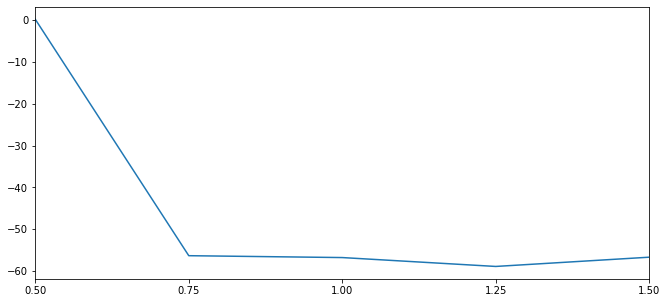

In [14]:
#utility changes (Hicksian equivalent variation)
Δ = ((Wlevels/W0)**(1/egam)-1)*100

# Figure 9.13 The optimal quantity of debt
fig, ax = plt.subplots(1)
ax.plot(blevels, Δ)
ax.set_xlim(0.5,1.5)
ax.set_xticks([0.5,0.75,1,1.25,1.5])